Small Business Hotspots by Industry and Area  
***Authored by:*** Yuvarani Dharmasivam  
***Duration:*** 90 minutes  
***Level:*** Intermediate  
***Pre-requisite Skills:*** Python  

### Scenario

The City of Melbourne wants to understand where small businesses are clustering by industry and location. This information is crucial for targeted economic development, resource allocation, and policymaking. By identifying business hotspots and analysing their trends over time, city authorities can support sustainable growth and address local business needs effectively.



### User Story
As an Economic Development Officer,I want to identify hotspots of small businesses across Melbourne’s suburbs by industry,so that I can design targeted support programs and allocate resources to promote local economic growth.
#### What this use case will teach you
At the end of this use case, you will be able to:
- Retrieve and access data by accessing a public API.
- Perform suburb wise and industry wise small business analysis
- Create interactive maps and visualisations to identify hotspots
- Analyse changes in hotspots over time using time series data

### Introduction

Small businesses are vital contributors to Melbourne’s economy, creating jobs and fostering innovation. However, their success and growth vary across the city and across industries. Using open datasets provided by the City of Melbourne, this project maps and analyses the spatial distribution of small businesses, tracks their evolution over time, and identifies potential future growth areas.
The insights generated will inform policymakers and support targeted economic initiatives that strengthen Melbourne’s local economy.

### Datasets Used

- Business Establishments and Jobs data by Business size and Industry — https://data.melbourne.vic.gov.au/explore/dataset/business-establishments-and-jobs-data-by-business-size-and-industry/api/  
- Business Establishments Location and Industry Classification — https://data.melbourne.vic.gov.au/explore/dataset/business-establishments-with-address-and-industry-classification/api/?disjunctive.industry_anzsic4_description&disjunctive.block_id&disjunctive.clue_small_area&disjunctive.industry_anzsic4_code

### Importing Necessary Libraries and Dataset Using API


In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import requests
import math
import folium
import itertools
import requests
import pandas as pd
import io
import os

def fetch_dataset_csv(base_url, dataset, api_key):
    # Build the CSV export URL
    suffix = 'exports/csv?delimiter=%3B&list_separator=%2C&quote_all=false&with_bom=true'
    url = f"{base_url}{dataset}/{suffix}"
    params = {'api_key': api_key}

    try:
        response = requests.get(url, params=params, timeout=10)
        response.raise_for_status()
    except requests.exceptions.RequestException as e:
        raise Exception(f"Failed to fetch data from API. Reason: {e}\nURL: {url}")

    # Parse the response as CSV
    try:
        df = pd.read_csv(io.BytesIO(response.content), delimiter=';')
    except Exception as e:
        raise Exception(f"Failed to parse CSV. Reason: {e}")

    return df
API_KEY = os.environ.get('MELBOURNE_API_KEY')
BASE_URL = 'https://data.melbourne.vic.gov.au/api/explore/v2.1/catalog/datasets/'

### Importing Business Establishment and Jobs Data by Business size and Industry


This dataset shows businesses and jobs grouped by business size and industry in different suburbs. This data is used to filter and analyse small businesses by suburb and industry.

In [2]:
dataset = 'business-establishments-and-jobs-data-by-business-size-and-industry'
df_business = fetch_dataset_csv(BASE_URL,dataset , API_KEY)
df_business.head(5)

,census_year,clue_small_area,anzsic_indusrty,clue_industry,business_size,total_establishments,total_jobs
0,2023,Melbourne (CBD),"Rental, Hiring and Real Estate Services",Real Estate Services,Small business,142,900.0
1,2023,Melbourne (Remainder),"Transport, Postal and Warehousing","Transport, Postal and Storage",Non employing,2,NaN
2,2023,North Melbourne,Financial and Insurance Services,Finance and Insurance,Non employing,2,NaN
3,2023,North Melbourne,Information Media and Telecommunications,Information Media and Telecommunications,Medium business,3,150.0
4,2023,North Melbourne,"Transport, Postal and Warehousing","Transport, Postal and Storage",Small business,12,55.0


### Importing Business Establishments Location and Industry Classification

This dataset provides the address, suburb, and geographic coordinates (latitude and longitude) for each business. It enables spatial analysis by mapping businesses across different locations.

In [3]:
dataset = 'business-establishments-with-address-and-industry-classification'
df_business_class = fetch_dataset_csv(BASE_URL,dataset , API_KEY)
df_business_class.head(5)

,census_year,block_id,property_id,base_property_id,clue_small_area,trading_name,business_address,industry_anzsic4_code,industry_anzsic4_description,longitude,latitude,point
0,2010,1101,110843,110843,Docklands,Vacant,163-235 Spencer Street DOCKLANDS 3008,0,Vacant Space,144.950564,-37.814509,"-37.8145089728263, 144.9505641424"
1,2010,1101,110843,110843,Docklands,Newsxpress,"Shop 302, Ground , 237-261 Spencer Street DOCK...",4244,Newspaper and Book Retailing,144.950564,-37.814509,"-37.8145089728263, 144.9505641424"
2,2010,1101,110843,110843,Docklands,Lifestyle Luggage,"Shop 102, Level 1, 163-261 Spencer Street DOCK...",4259,Other Personal Accessory Retailing,144.950564,-37.814509,"-37.8145089728263, 144.9505641424"
3,2010,1101,110843,110843,Docklands,Mo's Mobiles,"Shop 114, Level 1, 163-261 Spencer Street DOCK...",4229,Other Electrical and Electronic Goods Retailing,144.950564,-37.814509,"-37.8145089728263, 144.9505641424"
4,2010,1101,110843,110843,Docklands,Skechers,"Shop 34, Level 1, 163-261 Spencer Street DOCKL...",4252,Footwear Retailing,144.950564,-37.814509,"-37.8145089728263, 144.9505641424"


### Mapping industry divisions to ANZSIC codes


This dictionary maps industry sector names to their corresponding ANZSIC division codes. It is used to standardise industry classifications for analysis, enabling easier grouping, filtering, and comparison of business data across defined industry divisions.


In [4]:
division_map = {
    'Agriculture, Forestry and Fishing': 'A',
    'Mining': 'B',
    'Manufacturing': 'C',
    'Electricity, Gas, Water and Waste Services': 'D',
    'Construction': 'E',
    'Wholesale Trade': 'F',
    'Retail Trade': 'G',
    'Accommodation and Food Services': 'H',
    'Transport, Postal and Warehousing': 'I',
    'Information Media and Telecommunications': 'J',
    'Financial and Insurance Services': 'K',
    'Rental, Hiring and Real Estate Services': 'L',
    'Professional, Scientific and Technical Services': 'M',
    'Administrative and Support Services': 'N',
    'Public Administration and Safety': 'O',
    'Education and Training': 'P',
    'Health Care and Social Assistance': 'Q',
    'Arts and Recreation Services': 'R',
    'Other Services': 'S',
    'All ANZSIC': 'Z'  
}

### Map industry names to division codes in the DataFrame

This line creates a new column division_code in the df_business DataFrame by mapping the anzsic_indusrty industry names to their corresponding ANZSIC division codes using the division_map dictionary. This helps categorise businesses according to standardised industry divisions for easier analysis.

In [5]:
df_business['division_code'] = df_business['anzsic_indusrty'].map(division_map)

### Mapping Industry Codes to ANZSIC Divisions for Business Classification Dataset

For Dataset 2, which contains detailed business establishment information including ANZSIC 4-digit industry codes, the classify_division function is used to map each 4-digit code to its corresponding ANZSIC division letter. This enables grouping and analysis of businesses by broader industry divisions in the df_business_class DataFrame.

In [6]:
def classify_division(code):
    code = str(code).zfill(2)  # pad with zero if needed, e.g. '1' -> '01'
    
    if code.startswith(('01','02','03','04','05')):
        return 'A'
    elif code.startswith(('06','07','08','09','10')):
        return 'B'
    elif code.startswith(tuple(str(i).zfill(2) for i in range(11,26))):
        return 'C'
    elif code.startswith(('26','27','28','29')):
        return 'D'
    elif code.startswith(('30','31','32')):
        return 'E'
    elif code.startswith(('33','34','35','36','37','38')):
        return 'F'
    elif code.startswith(('39','40','41','42','43')):
        return 'G'
    elif code.startswith(('44','45')):
        return 'H'
    elif code.startswith(('46','47','48','49','50','51','52','53',)):
        return 'I'
    elif code.startswith(('54','55','56','57','58','59','60')):
        return 'J'
    elif code.startswith(('62','63','64')):
        return 'K'
    elif code.startswith(('66','67')):
        return 'L'
    elif code.startswith(('69','70')):
        return 'M'
    elif code.startswith(('72','73')):
        return 'N'
    elif code.startswith(('75','76','77')):
        return 'O'
    elif code.startswith(('80','81','82')):
        return 'P'
    elif code.startswith(('84','85','86','87')):
        return 'Q'
    elif code.startswith(('89','90','91','92')):
        return 'R'
    elif code.startswith(('94','95','96')):
        return 'S'
    else:
        return 'Z'

# Apply to Dataset 2
df_business_class['division_code'] = df_business_class['industry_anzsic4_code'].apply(classify_division)


### Data Cleaning and Preparation for Business Datasets

This code selects relevant columns from both business datasets and performs essential cleaning steps to prepare the data for analysis. It removes rows with missing key information, cleans text fields by trimming spaces and standardising capitalisation, and filters the main dataset to keep only small businesses. Duplicate records are dropped, and the DataFrames’ indexes are reset to ensure clean, consistent datasets ready for further exploration and modeling.

In [7]:
# Select relevant columns
df_business = df_business[['census_year', 'clue_small_area', 'anzsic_indusrty', 'business_size', 'total_establishments', 'total_jobs','division_code']].copy()
df_business_class = df_business_class[['census_year', 'clue_small_area', 'industry_anzsic4_description', 'longitude', 'latitude','division_code']].copy()


# Drop rows with missing key info
df_business = df_business.dropna(subset=['clue_small_area', 'anzsic_indusrty', 'total_establishments','division_code'])
df_business_class = df_business_class.dropna(subset=['clue_small_area', 'industry_anzsic4_description', 'latitude', 'longitude','division_code'])

# Clean text columns
df_business['clue_small_area'] = df_business['clue_small_area'].str.strip().str.title()
df_business['anzsic_indusrty'] = df_business['anzsic_indusrty'].str.strip().str.title()
df_business_class['clue_small_area'] = df_business_class['clue_small_area'].str.strip().str.title()
df_business_class['industry_anzsic4_description'] = df_business_class['industry_anzsic4_description'].str.strip().str.title()


# Filter for small businesses only
df_business = df_business[df_business['business_size'].str.lower() == 'small business']

# Drop duplicates
df_business = df_business.drop_duplicates()
df_business_class = df_business_class.drop_duplicates()

# reset index
df_business.reset_index(drop=True, inplace=True)
df_business_class.reset_index(drop=True, inplace=True)



### Aggregating and Visualising Business Establishments by Suburb and Industry

This code aggregates total business establishments by suburb and industry, then reshapes the data into a pivot table format with suburbs as rows and industries as columns. It ensures "City Of Melbourne (Total)" appears at the top of the table for easy comparison. The pivot table is cleaned by dropping irrelevant columns, and a heatmap is generated using Seaborn to visually represent the concentration of business establishments across different suburbs and industries.


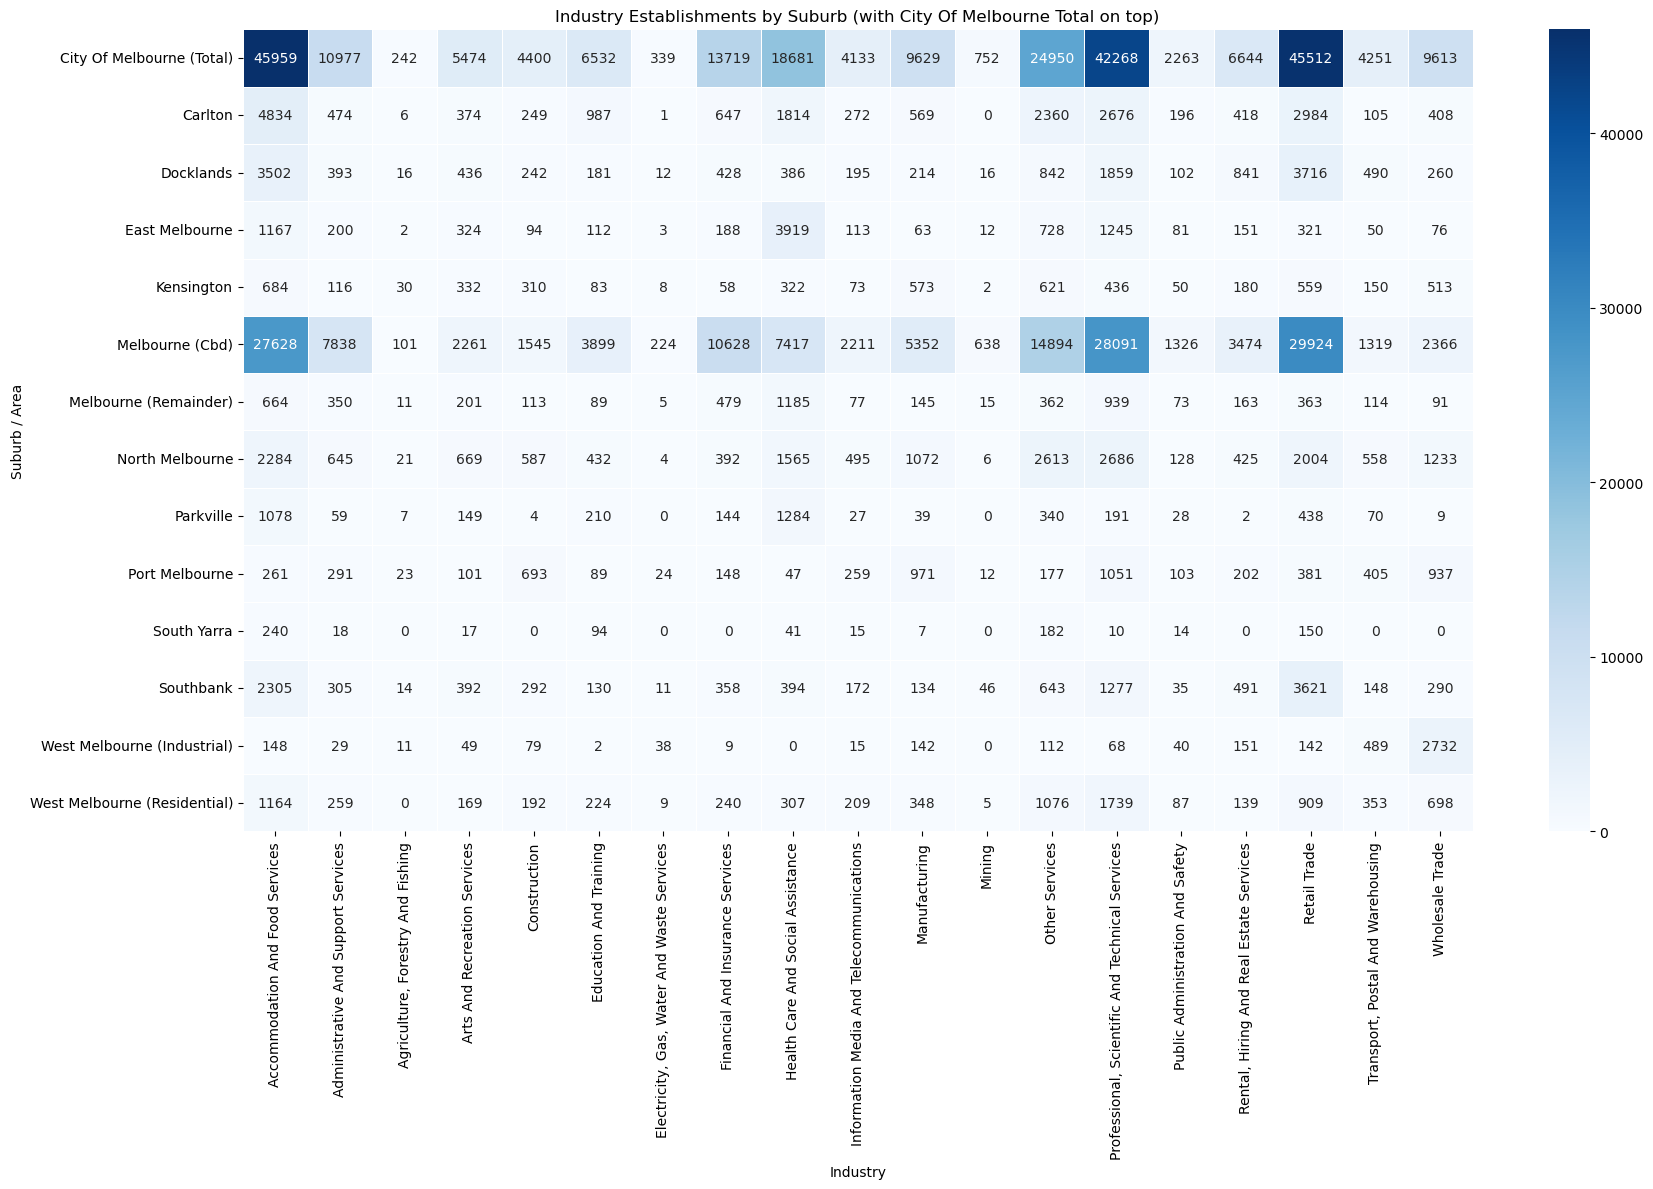

In [8]:
# Aggregate total establishments by suburb and industry
agg = df_business.groupby(['clue_small_area', 'anzsic_indusrty'])['total_establishments'].sum().reset_index()

# Your pivot table (suburbs x industries), including "City Of Melbourne (Total)"
pivot_df = agg.pivot(index='clue_small_area', columns='anzsic_indusrty', values='total_establishments').fillna(0)

# Create a custom order so that "City Of Melbourne (Total)" is on top
new_order = ['City Of Melbourne (Total)'] + [idx for idx in pivot_df.index if idx != 'City Of Melbourne (Total)']

# Convert index to categorical with this order
pivot_df.index = pd.CategoricalIndex(pivot_df.index, categories=new_order, ordered=True)

# Sort index based on this categorical order
pivot_df = pivot_df.sort_index()

columns_to_drop = ['All Anzsic'] 
pivot_df = pivot_df.drop(columns=columns_to_drop, errors='ignore') 

# Plot heatmap

plt.figure(figsize=(18, 12))
sns.heatmap(pivot_df, annot=True, fmt='.0f', cmap='Blues', linewidths=0.5)

plt.title('Industry Establishments by Suburb (with City Of Melbourne Total on top)')
plt.ylabel('Suburb / Area')
plt.xlabel('Industry')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()


#### Key Industry Hotspots

***1. City-Wide Trends***
- **Accommodation and Food Services**  
  Strong presence in **Melbourne CBD**, Carlton, Docklands, and smaller counts in other suburbs → reflects vibrant hospitality and tourism.  
- **Administrative and Support Services**  
  Noticeable in Melbourne CBD and city total; smaller counts elsewhere.  
- **Information Media and Telecommunications**  
  Extremely high in Melbourne CBD - major tech and media hub.  
- **Professional, Scientific and Technical Services**  
  Strong concentration in Melbourne CBD.  
- **Construction**  
  High in Melbourne CBD and Carlton due to ongoing development.  
- **Electricity, Gas, Water and Waste Services**  
  Significant in Melbourne CBD - infrastructure-heavy sector.  
- **Retail Trade**  
  Spread more evenly, but still highest in CBD.

***2. Smaller or Niche Sectors***
- **Agriculture, Forestry and Fishing** - Low counts, scattered.  
- **Mining** - Negligible in all suburbs.  
- **Manufacturing** - Low overall, with pockets in industrial areas.  
- **Transport, Postal & Warehousing** - Moderate counts, strongest in industrial zones.

***Suburb-Specific Profiles***
- **Carlton** - Education & Training, Arts & Recreation, Professional Services (university & cultural hub).  
- **Docklands** - Mixed industries, smaller counts; newer commercial precinct.  
- **Southbank** - Accommodation & Food, Arts & Recreation, Retail Trade.  
- **West Melbourne (Industrial)** - Manufacturing & Transport pockets.  
- **East Melbourne, Kensington, North Melbourne** - Lower overall counts, niche sectors.

***Notable Patterns***
- **Melbourne CBD dominates** nearly all industries.  
- Certain industries (e.g., **Information Media**) are highly concentrated in specific suburbs - specialised hubs.  
- Industrial and residential suburbs have lower overall counts except for manufacturing, transport, and warehousing.


### Top 3 Industries by Number of Establishments in Each Melbourne Suburb

This bar chart visualises the top three industries (based on the number of establishments) in each suburb within the City of Melbourne,. The data is grouped by suburb, sorted in descending order of establishment count, and displays the top three industries per suburb using distinct colors. This visualisation helps identify the most dominant industry sectors in different areas across Melbourne.

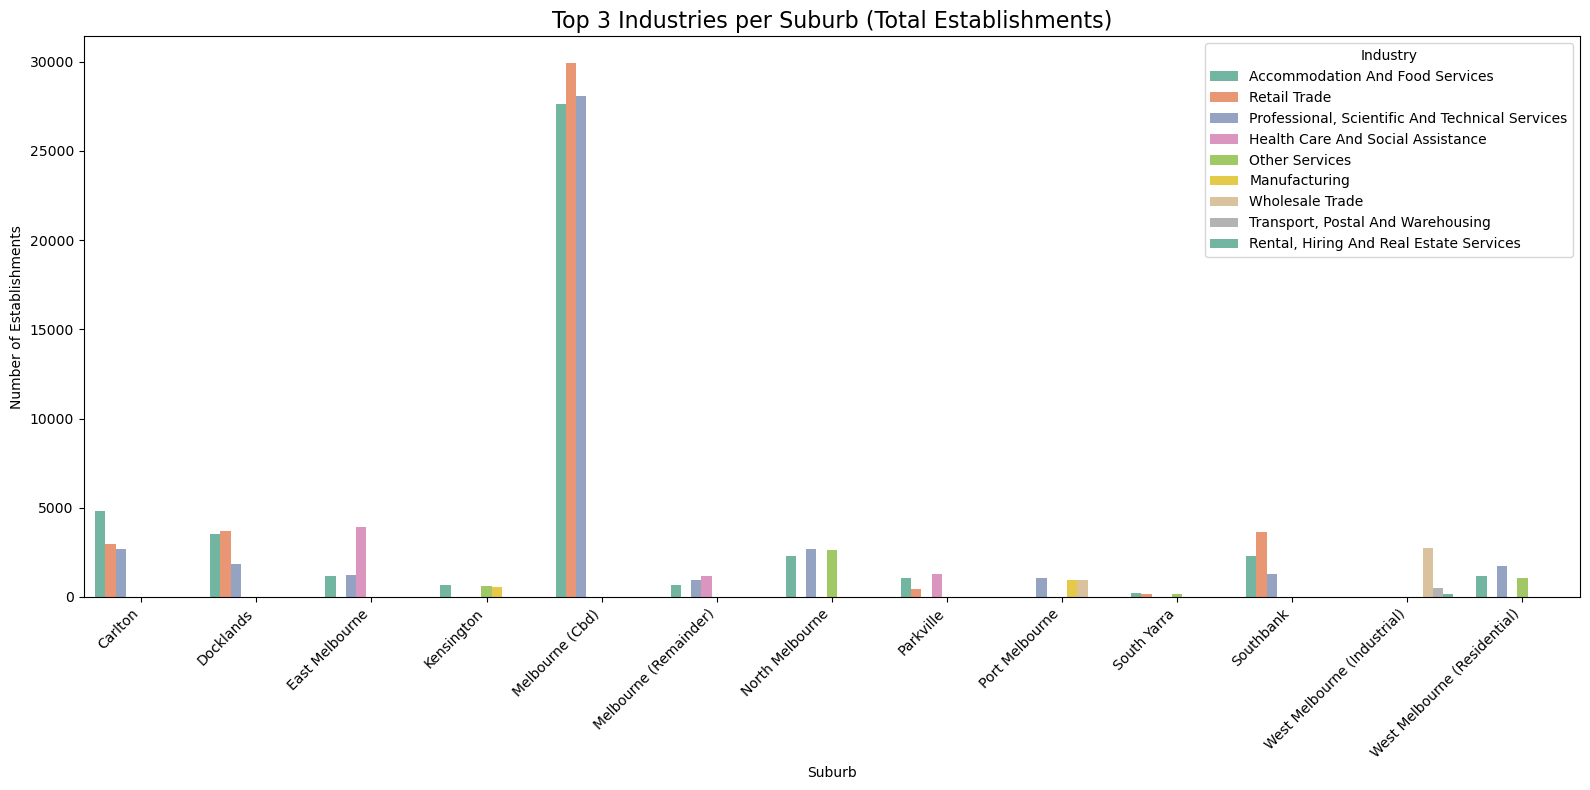

In [9]:
# Filter out 'City Of Melbourne (Total)' suburb and 'All Anzsic' industry
filtered_df = agg[(agg['clue_small_area'] != 'City Of Melbourne (Total)') & (agg['anzsic_indusrty'] != 'All Anzsic')]

# Sort by suburb and total establishments descending
agg_sorted = filtered_df.sort_values(['clue_small_area', 'total_establishments'], ascending=[True, False])

# Get top 3 industries per suburb
top3_per_suburb = agg_sorted.groupby('clue_small_area').head(3)

# Plot total establishments (raw counts)
plt.figure(figsize=(16, 8))
sns.barplot(data=top3_per_suburb,
            x='clue_small_area',
            y='total_establishments',
            hue='anzsic_indusrty',
            palette='Set2')

plt.title('Top 3 Industries per Suburb (Total Establishments)', fontsize=16)
plt.xlabel('Suburb')
plt.ylabel('Number of Establishments')
plt.xticks(rotation=45, ha='right')
plt.legend(title='Industry', loc='upper right')
plt.tight_layout()
plt.show()


### Top 3 Industries per Suburb

| Suburb                         | Top 3 Industries (in order)                                                      | Observation                                     |
|-------------------------------|-----------------------------------------------------------------------------------|-------------------------------------------------------------|
| **Melbourne (CBD)**           | Retail Trade, Accommodation & Food Services, Professional Services               | Dominant commercial core with >27,000 establishments        |
| **Carlton**                   | Accommodation & Food Services, Retail Trade, Professional Services               | Diverse commercial activity, close to CBD                   |
| **Docklands**                 | Retail Trade, Accommodation & Food Services, Professional Services               | New mixed-use development                                   |
| **East Melbourne**            | Health Care & Social Assistance, Professional Services, Other Services           | Medical and administrative hub                              |
| **Parkville**                 | Health Care & Social Assistance, Other Services, Professional Services           | Strong health and research presence                         |
| **West Melbourne (Industrial)** | Manufacturing, Transport & Warehousing, Wholesale Trade                        | Industrial and logistics-focused                            |
| **West Melbourne (Residential)** | Health Care & Social Assistance, Other Services, Professional Services       | Balanced residential and light commercial mix               |
| **North Melbourne**           | Health Care & Social Assistance, Other Services, Professional Services           | Mixed-use zoning                                            |
| **Port Melbourne**            | Manufacturing, Wholesale Trade, Professional Services                            | Industrial character                                        |
| **Southbank**                 | Retail Trade, Accommodation & Food Services, Professional Services               | Entertainment and commercial precinct                       |
| **South Yarra**               | Real Estate Services, Professional Services, Other Services                       | Niche commercial services, smaller footprint                |
| **Kensington**                | Professional Services, Other Services, Manufacturing                              | Limited but diverse industry presence                       |


### Top 3 Industries per Suburb (Percentage of Total Establishments)

This bar chart illustrates the relative proportion of the top three industries in each suburb, expressed as a percentage of total establishments within that suburb. Unlike the raw count version, this view highlights the dominance or balance of industry types at a local level, regardless of overall suburb size.

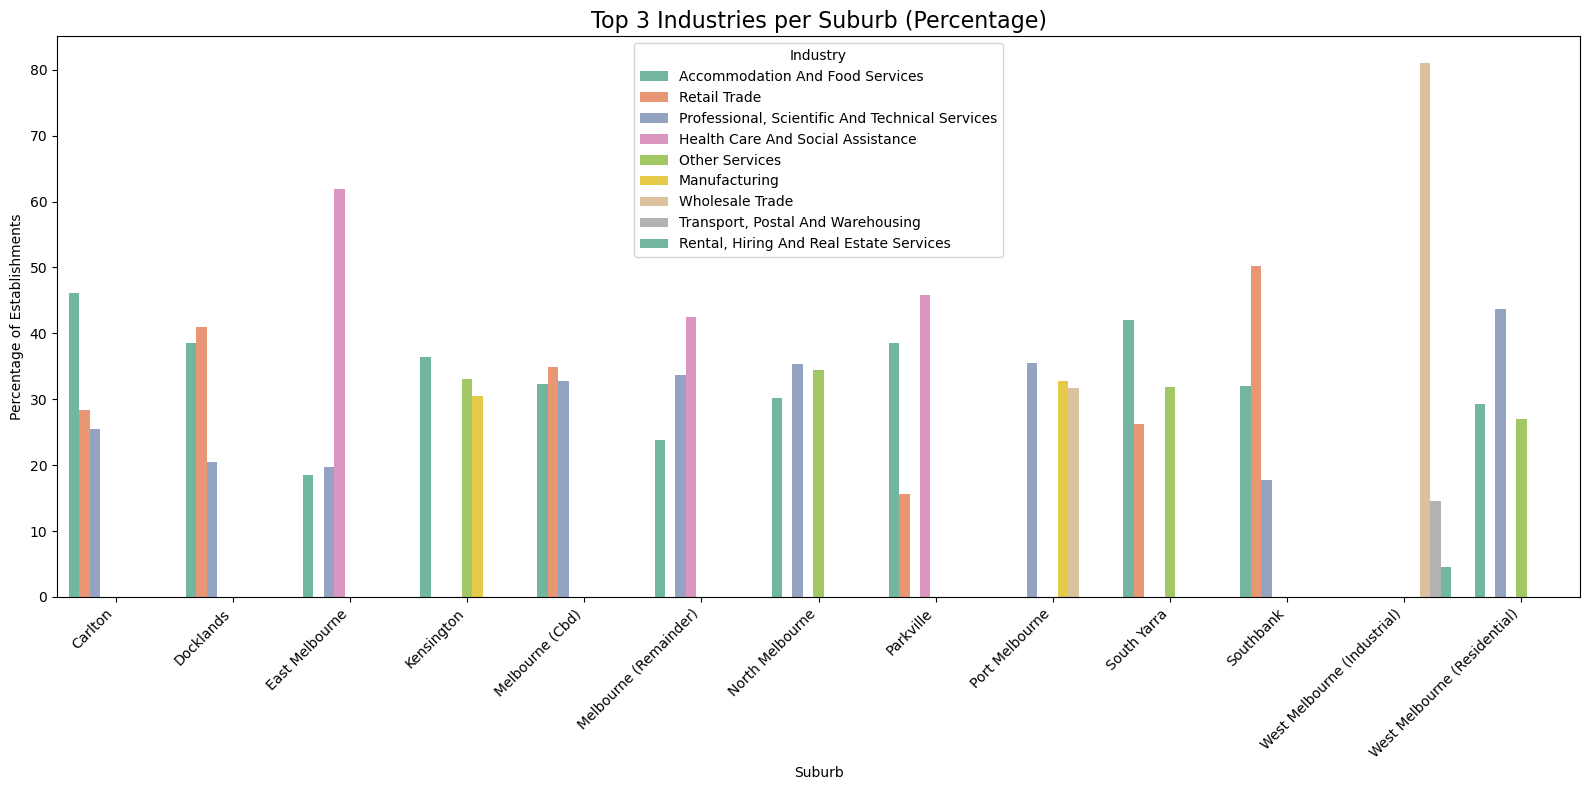

In [10]:
# Calculate percentage 
top3_per_suburb = top3_per_suburb.copy()
top3_per_suburb['percentage'] = top3_per_suburb.groupby('clue_small_area')['total_establishments'] \
                                               .transform(lambda x: x / x.sum() * 100)

# Plot percentage version
plt.figure(figsize=(16, 8))
sns.barplot(data=top3_per_suburb,
            x='clue_small_area',
            y='percentage',
            hue='anzsic_indusrty',
            palette='Set2')

plt.title('Top 3 Industries per Suburb (Percentage)', fontsize=16)
plt.xlabel('Suburb')
plt.ylabel('Percentage of Establishments')
plt.xticks(rotation=45, ha='right')
plt.legend(title='Industry', loc='upper center')
plt.tight_layout()
plt.show()


### Key Observations

- **East Melbourne** is mostly made up of health-related businesses (over 60%).
- **West Melbourne (Industrial)** is heavily dominated by manufacturing (over 80%).
- **Parkville**, **North Melbourne**, and **Melbourne (Remainder)** also have a strong focus on health services.
- **Carlton** and **Docklands** have a balanced mix of industries without one clearly dominating.
- **Southbank** is led by retail and food services, especially retail (around 50%).
- **South Yarra**, **Kensington**, and **Port Melbourne** show more even distribution across the top 3 industries.


### Interpretation & Implications

- Suburbs like East Melbourneand West Melbourne (Industrial) are highly specialised, which may boost efficiency but can increase vulnerability to industry-specific shocks.
- Suburbs with a more even spread, like Carlton, Docklands, and South Yarra, may be more resilient to economic fluctuations.

### Top 3 Industries Over Time in Each Suburb

This visual tracks the change in total establishments for the top 3 industries in each suburb within the City of Melbourne over multiple census years.

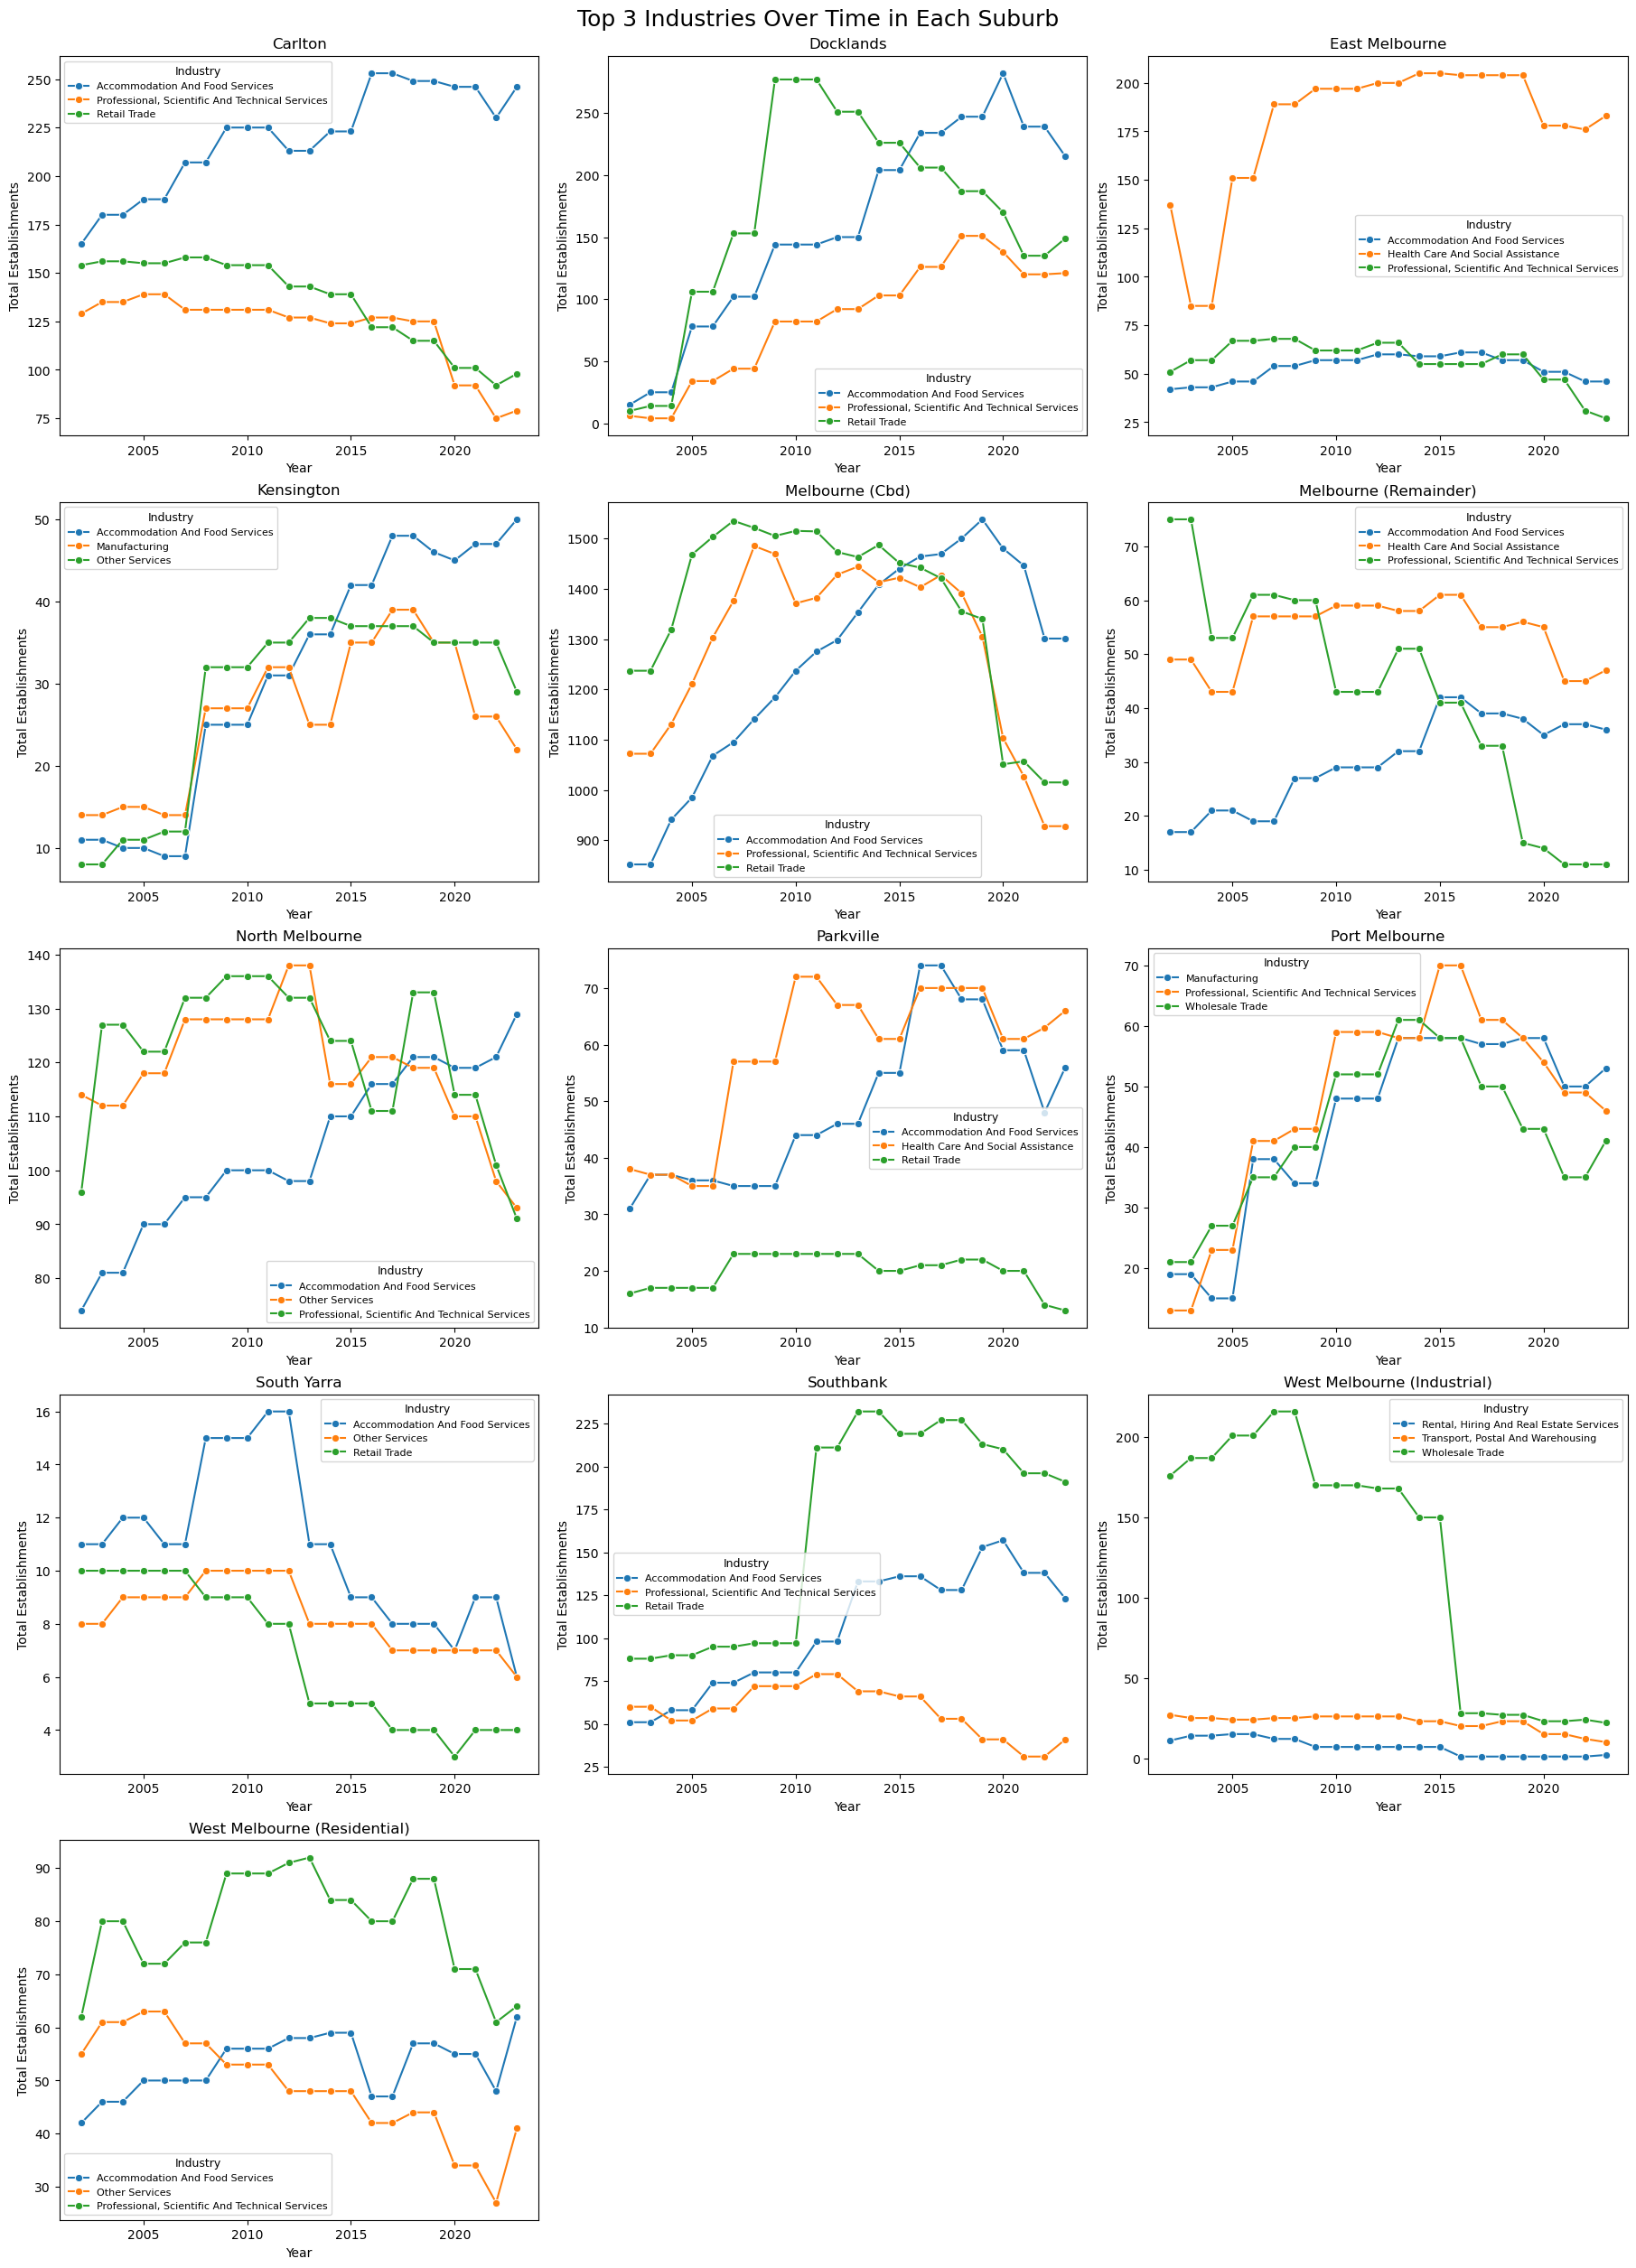

In [11]:

# Aggregate total establishments per year, suburb, industry
agg = df_business.groupby(['census_year', 'clue_small_area', 'anzsic_indusrty'])['total_establishments'].sum().reset_index()

# Remove aggregate suburb/industry rows if present
filtered_df = agg[
    (agg['clue_small_area'] != 'City Of Melbourne (Total)') &
    (agg['anzsic_indusrty'] != 'All Anzsic')
]

# Identify top 3 industries per suburb (based on total across all years)
agg_total = filtered_df.groupby(['clue_small_area', 'anzsic_indusrty'])['total_establishments'].sum().reset_index()
agg_sorted = agg_total.sort_values(['clue_small_area', 'total_establishments'], ascending=[True, False])
top3_per_suburb = agg_sorted.groupby('clue_small_area').head(3)

# Filter original (yearly) data for just these top 3 industries
top_industries_df = pd.merge(filtered_df, top3_per_suburb[['clue_small_area', 'anzsic_indusrty']], 
                             on=['clue_small_area', 'anzsic_indusrty'], how='inner')

# Create subplots: one per suburb
suburbs = top_industries_df['clue_small_area'].unique()
num_suburbs = len(suburbs)
cols = 3
rows = math.ceil(num_suburbs / cols)

fig, axes = plt.subplots(rows, cols, figsize=(cols * 6, rows * 5), constrained_layout=True)
axes = axes.flatten()

for i, suburb in enumerate(suburbs):
    ax = axes[i]
    data = top_industries_df[top_industries_df['clue_small_area'] == suburb]
    
    sns.lineplot(data=data, x='census_year', y='total_establishments', hue='anzsic_indusrty', 
                 marker='o', ax=ax)
    
    ax.set_title(f'{suburb}')
    ax.set_xlabel('Year')
    ax.set_ylabel('Total Establishments')
    ax.legend(title='Industry', fontsize=8, title_fontsize=9, loc='best')
    
# Hide unused axes if any
for j in range(i + 1, len(axes)):
    axes[j].axis('off')

plt.suptitle('Top 3 Industries Over Time in Each Suburb', fontsize=18)
plt.show()


### Top 3 Industries Over Time – Suburb Trend Analysis

***Carlton***
- **Accommodation and Food Services**: Steady growth from ~160 in 2002 to ~250 by 2010, stable afterward.  
- **Professional, Scientific and Technical Services**: Gradual decline since ~2010.  
- **Retail Trade**: Decline from ~2013, sharp drop around 2020 (likely COVID impact).  

***Docklands***
- Rapid rise in all industries between 2006–2009, likely due to redevelopment.  
- **Retail Trade**: Peaked ~2009–2010, then steady decline.  
- **Accommodation and Food Services**: Strong growth, slight drop post-2020.  
- **Professional Services**: Rising until ~2018, then plateau.  

***East Melbourne***
- **Health Care and Social Assistance** dominates since 2005; stable with small post-2020 dip.  
- **Accommodation and Food Services** and **Professional Services**: Much smaller share, steady/slightly declining.  

***Kensington***
- Small-scale market compared to CBD.  
- **Accommodation and Food Services**: Steady growth, surpassing others by ~2018.  
- **Manufacturing** and **Other Services**: Peaked ~2016, declining since.  

***Melbourne (CBD)***
- Large-scale activity in all three industries, peaking between 2010–2016.  
- **Accommodation and Food Services**: Peaked ~2020 (~1,550 establishments), sharp drop after.  
- **Professional Services** and **Retail Trade**: Decline since ~2014.  

***Melbourne (Remainder)***
- **Accommodation and Food Services**: Slow growth until ~2020, slight dip after.  
- **Professional Services**: Steady decline since ~2004.

***North Melbourne***
- **Accommodation and Food Services**: Gradual growth until ~2015, then plateau.  
- **Other Services** and **Professional Services**: Mild declines after 2015.  

***Parkville***
- **Health Care** dominates, growth until ~2013 then plateau.  
- **Accommodation and Food Services**: Growth until ~2016, then slight decline.  

***Port Melbourne***
- All three industries grew strongly from ~2004–2015, then gradual decline.  
- **Manufacturing** and **Professional Services** slightly stronger than **Wholesale Trade** in later years.  

***South Yarra***
- Small-scale market.  
- **Accommodation and Food Services**: Peaked ~2010–2012, then declined.  
- **Retail Trade**: Declining since 2010.  

***Southbank***
- **Retail Trade** dominates, peaked ~2013 then declined.  
- **Accommodation and Food Services**: Steady growth until ~2019.  
- **Professional Services**: Declining after ~2012.  

***West Melbourne (Industrial)***
- **Wholesale Trade** dominated until dramatic collapse ~2015 (likely rezoning/relocation).  
- Other industries small and stable.  

***West Melbourne (Residential)***
- **Professional Services** dominant, peaked ~2014, gradual decline since.  
- **Accommodation and Food Services**: Steady growth.  
- **Other Services**: Declining since ~2010.  

***Overall Patterns***
- **Accommodation and Food Services** grew across most suburbs until ~2019–2020, then dipped (COVID-19 effect).  
- **Retail Trade** shows long-term decline, reflecting e-commerce growth and shifting shopping habits.  
- **Professional Services** peaked earlier (2010–2015) and declined in many areas since.  
- Redevelopment areas (Docklands, Southbank) saw rapid industry growth followed by stabilisation/decline.  
- Industrial zones (e.g., West Melbourne Industrial) experienced major shifts due to land use changes.  


### Mapping Top 3 Industry Hotspots in Every Suburb

This interactive map visualises the geographic centroids of the top three industries in each Melbourne suburb, based on the total number of business establishments.Each coloured marker represents an industry, and its position is the average location of all businesses in that category within the suburb.

In [12]:
# Get top 3 industries per suburb
top3_by_suburb = (
    df_business.groupby(['clue_small_area', 'division_code'])['total_establishments']
    .sum().reset_index()
    .sort_values(['clue_small_area', 'total_establishments'], ascending=[True, False])
    .groupby('clue_small_area')
    .head(3)
)

# Merge with business locations to get lat/lon
df_top3_geo = pd.merge(
    df_business_class,
    top3_by_suburb[['clue_small_area', 'division_code']],
    on=['clue_small_area', 'division_code'],
    how='inner'
)

# Map division_code to industry name
division_to_industry = (
    df_business[['division_code', 'anzsic_indusrty']]
    .drop_duplicates()
    .set_index('division_code')['anzsic_indusrty']
    .to_dict()
)
df_top3_geo['industry_name'] = df_top3_geo['division_code'].map(division_to_industry)

# Compute centroids for each (suburb, industry)
df_centroids = (
    df_top3_geo
    .groupby(['clue_small_area', 'industry_name'])[['latitude', 'longitude']]
    .mean()
    .reset_index()
)

# Create folium map
fig = folium.Figure(width=600, height=400)
m = folium.Map(location=[-37.8136, 144.9631], zoom_start=12)
m.add_to(fig)

# Add centroid markers grouped by industry
industries = df_centroids['industry_name'].unique()
colors = itertools.cycle([
    'red', 'blue', 'green', 'purple', 'orange',
    'darkred', 'cadetblue', 'darkgreen', 'pink', 'black'
])

for industry, color in zip(industries, colors):
    group = folium.FeatureGroup(name=industry)
    sub_df = df_centroids[df_centroids['industry_name'] == industry]

    for _, row in sub_df.iterrows():
        popup_text = f"{row['clue_small_area']}<br>{industry}"
        folium.Marker(
            location=[row['latitude'], row['longitude']],
            popup=popup_text,
            icon=folium.Icon(color=color, icon='industry', prefix='fa')
        ).add_to(group)

    group.add_to(m)

# Add layer control
folium.LayerControl().add_to(m)

# Display the map
m
